In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib import ticker
from statsmodels.tsa.stattools import adfuller, acf, pacf
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [2]:
store_df = pd.read_csv('store.csv', parse_dates = True, low_memory = False)

In [3]:
train_df = pd.read_csv('train.csv', parse_dates = True, low_memory = False)

In [4]:
test_df = pd.read_csv('test.csv', parse_dates = True, low_memory = False)

#### Isolate the Rossmann Store Sales dataset into time series data

In [5]:
## check only Year 2014 of store = 1

sales_df = train_df[['Date', 'Sales']].set_index('Date')
sales_df.head()

,Sales
Date,
2015-07-31,5263
2015-07-31,6064
2015-07-31,8314
2015-07-31,13995
2015-07-31,4822


In [6]:
# Scale sales data
scaler = MinMaxScaler()
sales_df['SalesScaled'] = scaler.fit_transform(sales_df[['Sales']])

sales_df.head()

,Sales,SalesScaled
Date,,
2015-07-31,5263,0.126664
2015-07-31,6064,0.145941
2015-07-31,8314,0.200091
2015-07-31,13995,0.336815
2015-07-31,4822,0.116050


In [7]:
sales_df.describe()
sales_df.shape

(1017209, 2)

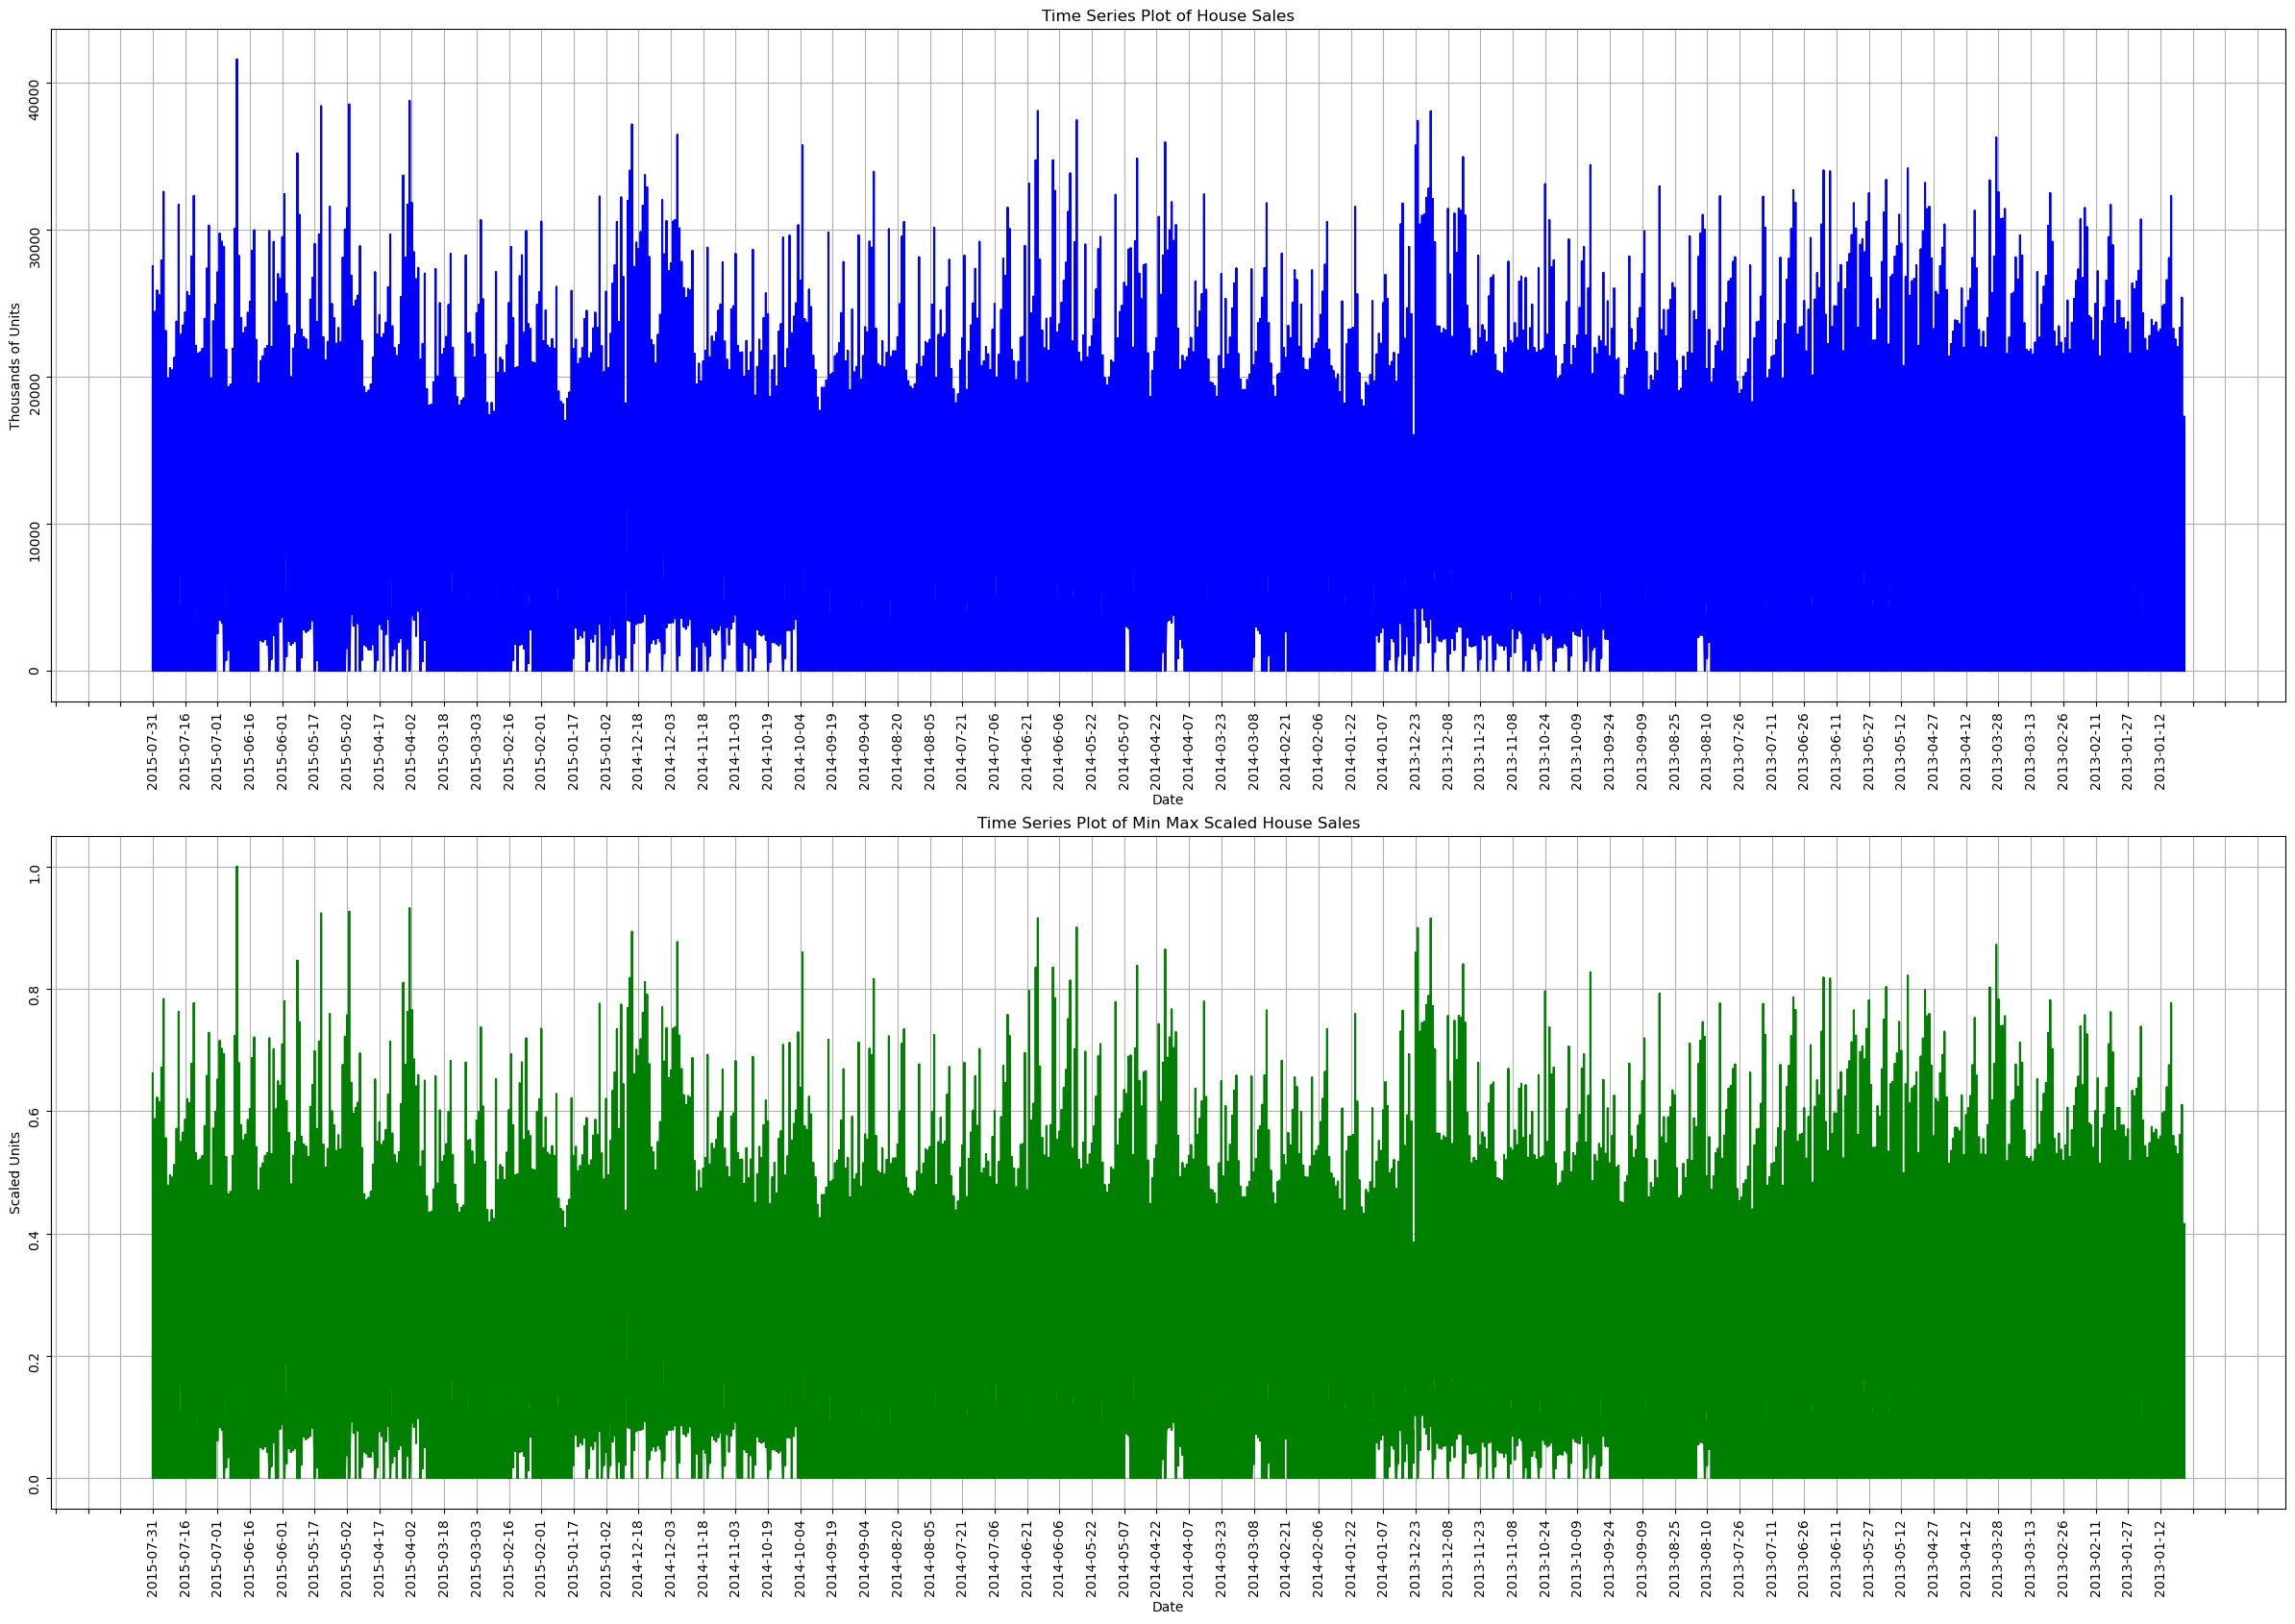

In [8]:
fig = plt.figure()
gs = GridSpec(2, 1, figure=fig)

fig.set_figheight(20)
fig.set_figwidth(30)
fig.tight_layout(pad=15)

M = 100
xticks = ticker.MaxNLocator(M)

ax1 = fig.add_subplot(gs[0,0])
ax1.plot(sales_df.index, sales_df.Sales, 'b-')
ax1.xaxis.set_major_locator(xticks)
ax1.tick_params(labelrotation=90)
ax1.set_xlabel('Date')
ax1.set_ylabel('Thousands of Units')
ax1.title.set_text('Time Series Plot of House Sales')
ax1.grid(True)

ax2 = fig.add_subplot(gs[1,0])
ax2.plot(sales_df.index, sales_df.SalesScaled, 'g-')
ax2.xaxis.set_major_locator(xticks)
ax2.tick_params(labelrotation=90)
ax2.set_xlabel('Date')
ax2.set_ylabel('Scaled Units')
ax2.title.set_text('Time Series Plot of Min Max Scaled House Sales')
ax2.grid(True)
plt.show()

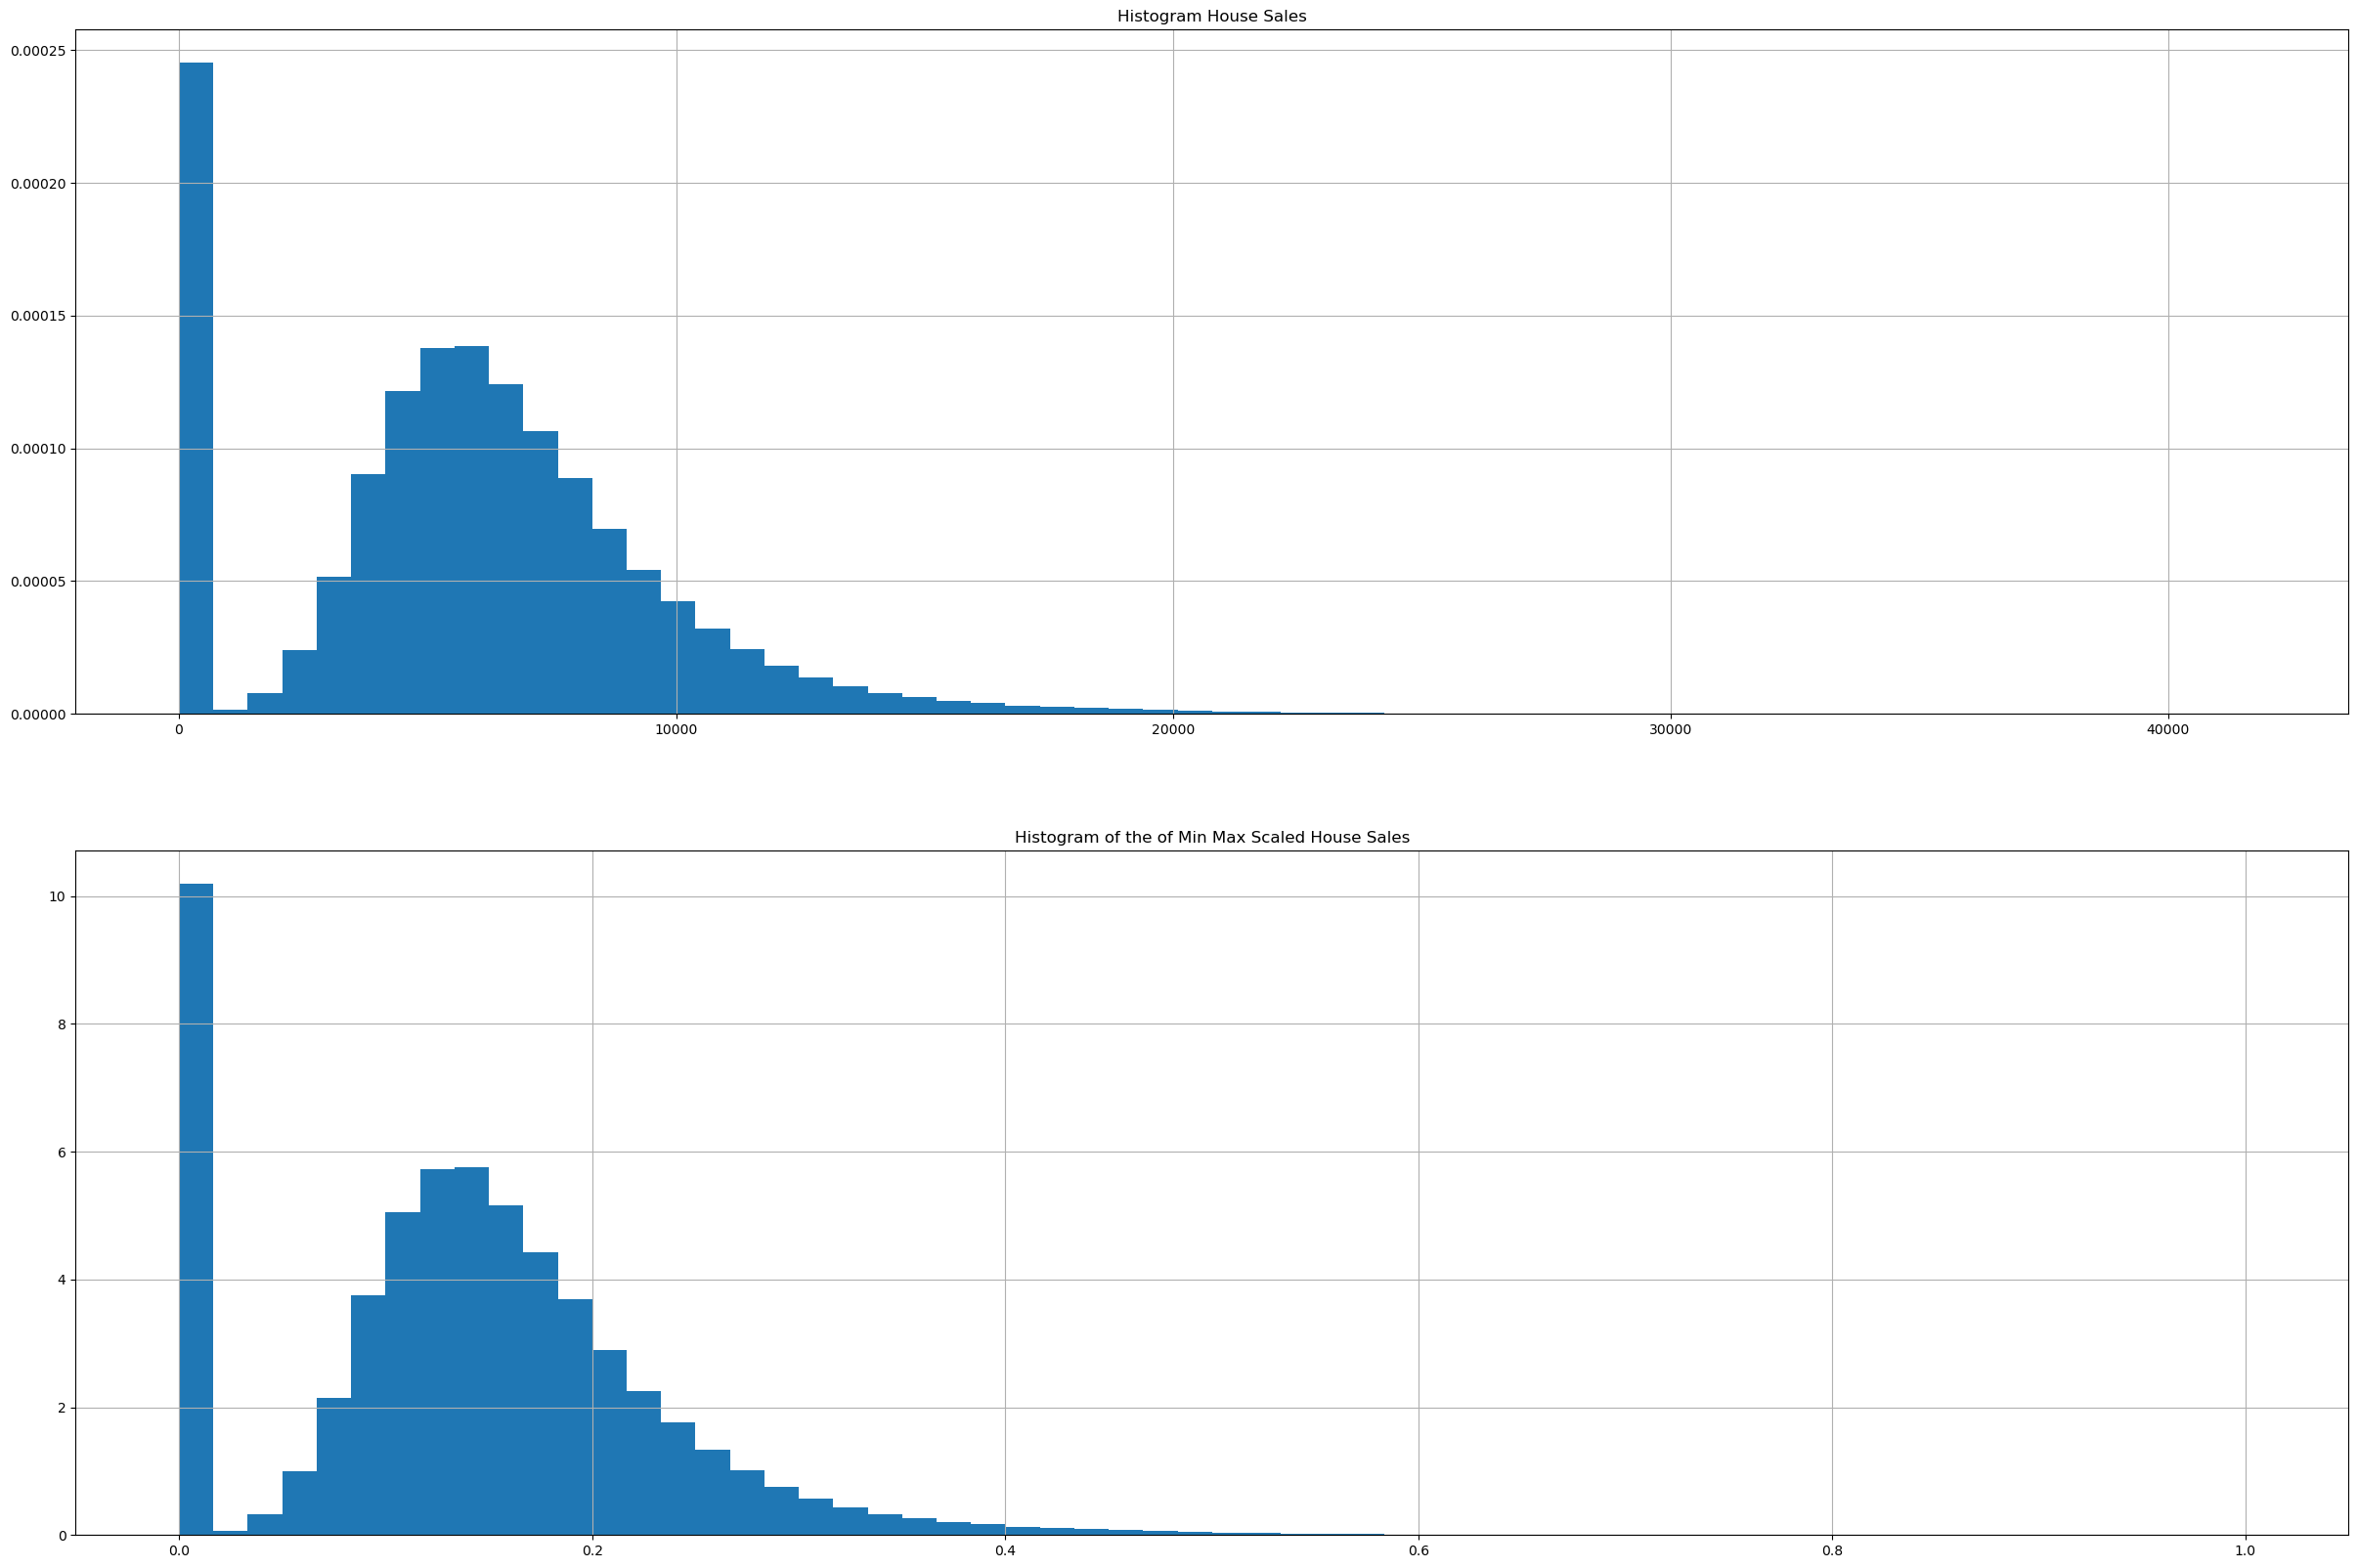

In [9]:
fig = plt.figure()
gs = GridSpec(2, 1, figure=fig)

fig.set_figheight(20)
fig.set_figwidth(30)
fig.tight_layout(pad=6)

ax1 = fig.add_subplot(gs[0,0])
ax1.hist(sales_df.Sales, density=True, bins=60)
ax1.title.set_text('Histogram House Sales')
ax1.grid(True)

ax2 = fig.add_subplot(gs[1,0])
ax2.hist(sales_df.SalesScaled, density=True, bins=60)
ax2.title.set_text('Histogram of the of Min Max Scaled House Sales')
ax2.grid(True)
plt.show()

#### Check whether your time Series Data is Stationary 

In [13]:
from statsmodels.tsa.stattools import kpss

# Perform the KPSS test
kpss_result = kpss(sales_df.Sales.values, regression='c')

# Print the KPSS test results
print(f'KPSS Statistic: {kpss_result[0]}')
print(f'p-value: {kpss_result[1]}')
print('Critical Values:')
for key, value in kpss_result[3].items():
    print(f'   {key}: {value}')

# Interpret the results
if kpss_result[1] < 0.05:
    print('KPSS test result: Non-stationary (reject null hypothesis)')
else:
    print('KPSS test result: Stationary (fail to reject null hypothesis)')

KPSS Statistic: 0.7011624739492017
p-value: 0.013439775095527115
Critical Values:
   10%: 0.347
   5%: 0.463
   2.5%: 0.574
   1%: 0.739
KPSS test result: Non-stationary (reject null hypothesis)


In [16]:
# Perform the KPSS test on the 'SalesScaled' data
kpss_result = kpss(sales_df.SalesScaled.values, regression='c', nlags='auto')

# Print the KPSS test results
print(f'KPSS Statistic: {kpss_result[0]}')
print(f'p-value: {kpss_result[1]}')
print(f'Number of lags used: {kpss_result[2]}')
print('Critical Values:')
for key, value in kpss_result[3].items():
    print(f'   {key}: {value}')

# Interpret the results
if kpss_result[1] < 0.05:
    print('KPSS test result: Non-stationary (reject null hypothesis)')
else:
    print('KPSS test result: Stationary (fail to reject null hypothesis)')

KPSS Statistic: 0.7011624739400044
p-value: 0.013439775096363234
Number of lags used: 553
Critical Values:
   10%: 0.347
   5%: 0.463
   2.5%: 0.574
   1%: 0.739
KPSS test result: Non-stationary (reject null hypothesis)


### Depending on your conclusion from 2 above difference your time series data

In [10]:
# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return pd.Series(diff)

salesScaledDiff = difference(sales_df.SalesScaled.values)
salesScaledDiff

0          0.019278
1          0.054150
2          0.136724
3         -0.220765
4          0.019951
             ...   
1017203    0.000000
1017204    0.000000
1017205    0.000000
1017206    0.000000
1017207    0.000000
Length: 1017208, dtype: float64

### Transform the time series data into supervised learning data by creating a new y(target) column. As illustrated here in the Sliding Window For Time Series Data section

In [11]:
acfSalesScaled = acf(sales_df.SalesScaled.values, fft=True, nlags=40)
acfSalesScaledNp = np.array(acfSalesScaled)

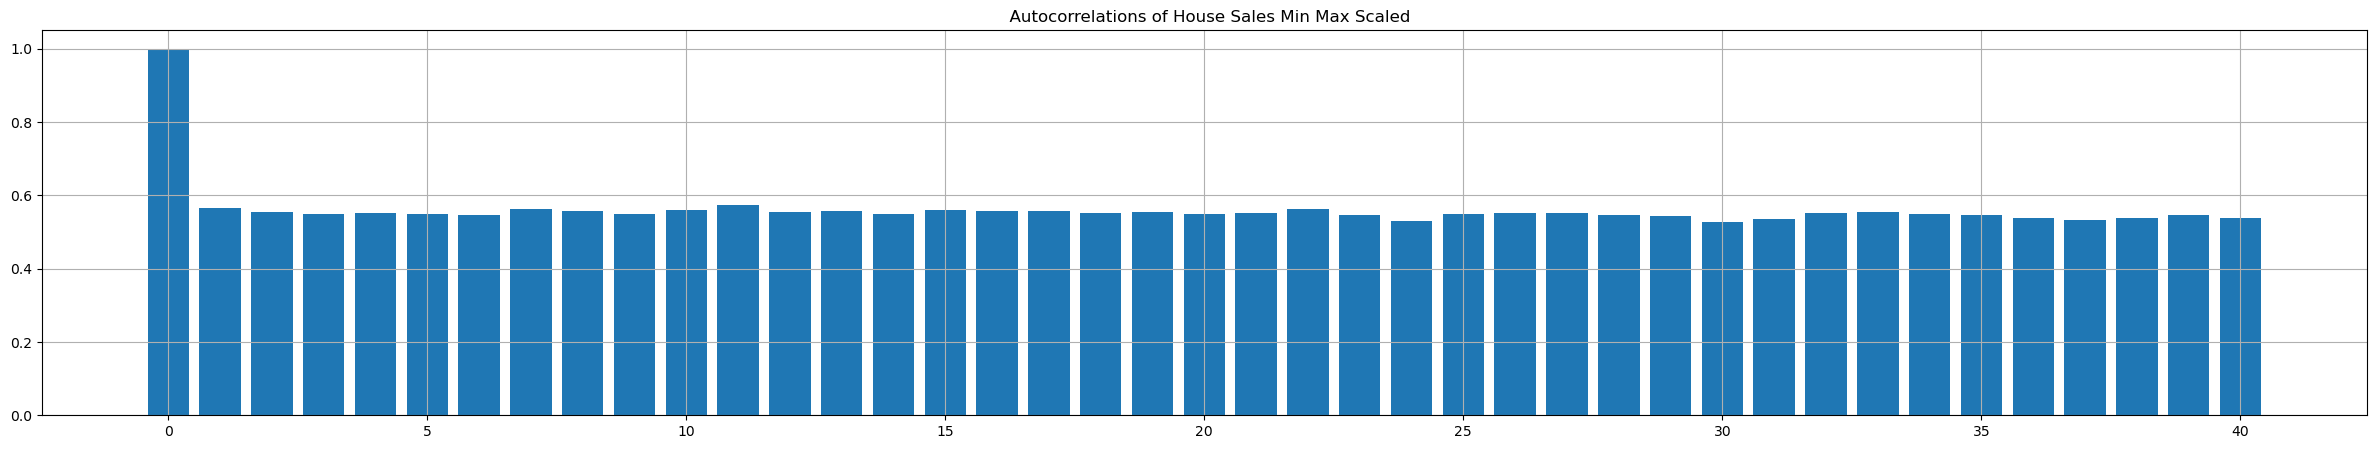

In [12]:
def corrPlots(array: np.array, prefix: str):
    plt.figure(figsize=(30, 5))
    plt.title(f"{prefix}  Autocorrelations of House Sales Min Max Scaled")
    plt.bar(range(len(array)), array)
    plt.grid(True)
    plt.show()
corrPlots(acfSalesScaledNp, '')

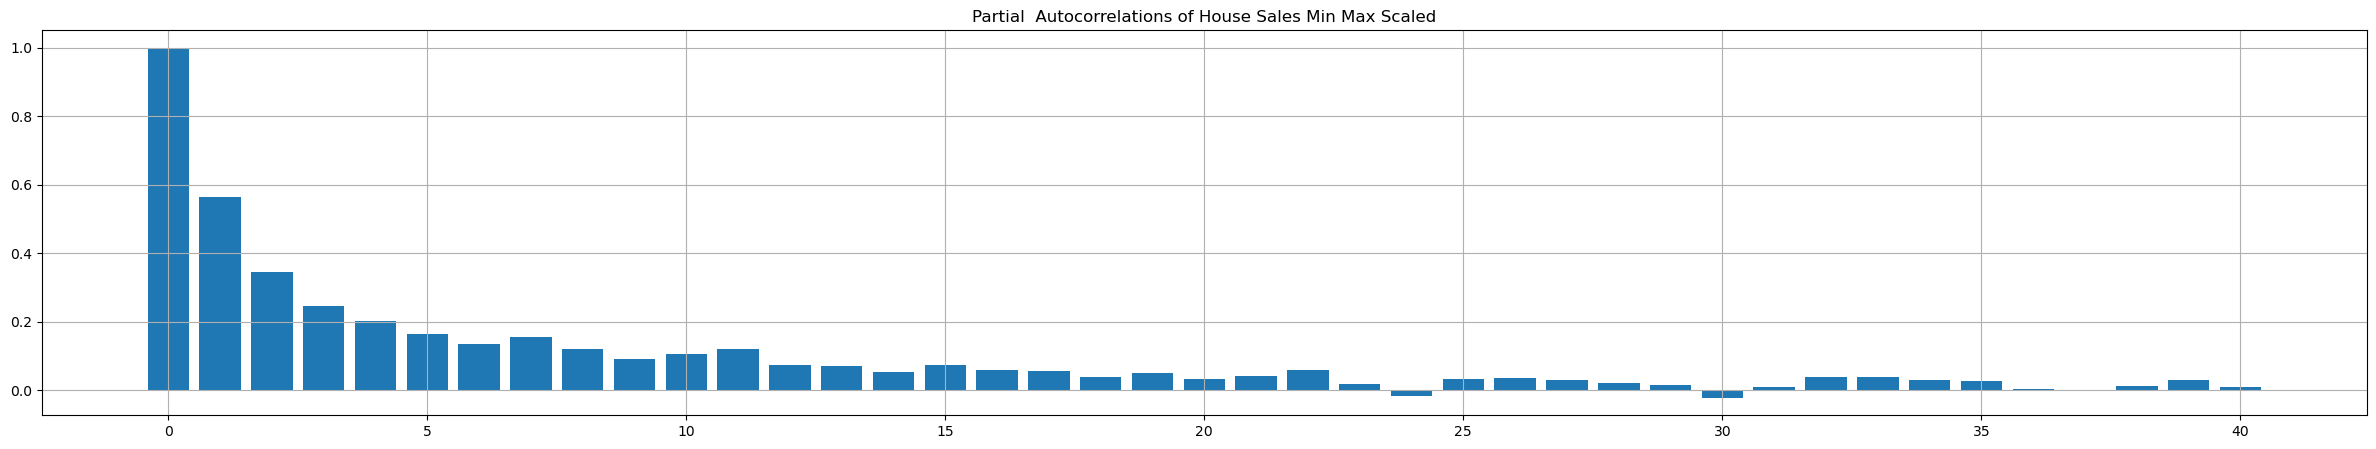

In [13]:
pacfSalesScaled = pacf(sales_df.SalesScaled.values, nlags=40)
pacfSalesScaledNp = np.array(pacfSalesScaled)
corrPlots(pacfSalesScaledNp, "Partial")

In [14]:
SIZE = len(sales_df.SalesScaled)
WINDOW_SIZE = 48
BATCH_SIZE= SIZE-WINDOW_SIZE*2
EPOCHS = 200

In [15]:
DateTrain = sales_df.index.values[0:BATCH_SIZE]
DateValid = sales_df.index.values[BATCH_SIZE:]
XTrain = sales_df.SalesScaled.values[0:BATCH_SIZE].astype('float32')
XValid = sales_df.SalesScaled.values[BATCH_SIZE:].astype('float32')

# Obtain shapes for vectors of size (,1) for dates series

DateTrain = np.reshape(DateTrain, (-1, 1))
DateValid = np.reshape(DateValid, (-1, 1))

print("Shape of the training set date series: ", DateTrain.shape)
print("Shape of the validation set date series: ", DateValid.shape)
print()
print("Shape of the training set logarithm of sales series: ", XTrain.shape)
print("Shape of the validation set logarithm of sales series in a stateless LSTM: ", XValid.shape)

Shape of the training set date series:  (1017113, 1)
Shape of the validation set date series:  (96, 1)

Shape of the training set logarithm of sales series:  (1017113,)
Shape of the validation set logarithm of sales series in a stateless LSTM:  (96,)


In [16]:
tf.random.set_seed(1234)
# add extra dimension
series = tf.expand_dims(XTrain, axis=-1)
series.shape

TensorShape([1017113, 1])

In [17]:
# create tensor from each individual element
dataset = tf.data.Dataset.from_tensor_slices(series)
dataset

<_TensorSliceDataset element_spec=TensorSpec(shape=(1,), dtype=tf.float32, name=None)>

In [18]:
# takes a window_size + 1 chunk from the slices
dataset = dataset.window(WINDOW_SIZE + 1, shift=1, drop_remainder=True) 

In [ ]:
# Example of Window
# datasetEx = tf.data.Dataset.from_tensor_slices(tf.range(10))
# datasetEx = datasetEx.window(5, shift=1, drop_remainder=True)
# for window in datasetEx:
#     print([elem.numpy() for elem in window])

In [19]:
dataset = dataset.flat_map(lambda window: window.batch(WINDOW_SIZE + 1))

In [20]:
dataset = dataset.batch(BATCH_SIZE).prefetch(1)

In [21]:
def windowed_dataset(series, window_size=WINDOW_SIZE, batch_size=BATCH_SIZE): 
    series = tf.expand_dims(series, axis=-1)
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True) 
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.map(lambda window: (window[:-1], window[-1:]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

In [22]:
DatasetTrain = windowed_dataset(XTrain)
DatasetVal = windowed_dataset(XValid)

### Define and Estimate the LSTM

In [23]:
model = Sequential()
model.add(LSTM(8, input_shape=[None, 1], return_sequences=True))
model.add(LSTM(4, input_shape=[None, 1]))
model.add(Dense(1))
model.compile(loss="huber_loss", optimizer='adam')

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 8)           320       
                                                                 
 lstm_1 (LSTM)               (None, 4)                 208       
                                                                 
 dense (Dense)               (None, 1)                 5         
                                                                 
Total params: 533 (2.08 KB)
Trainable params: 533 (2.08 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
history = model.fit(DatasetTrain, epochs=EPOCHS, validation_data=DatasetVal, verbose=1)

In [ ]:
fig = plt.figure()
plt.plot(history.history['loss'], label="loss")
plt.plot(history.history['val_loss'], label="val_loss")
plt.legend()
plt.show()

In [27]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True) 
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(SIZE).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [ ]:
Forecast = model_forecast(model, sales_df.SalesScaled.values[:, np.newaxis], WINDOW_SIZE)
Results = Forecast[BATCH_SIZE-WINDOW_SIZE:-1]
Results1 = scaler.inverse_transform(Results.reshape(-1,1))
XValid1 = scaler.inverse_transform(XValid.reshape(-1,1))

In [ ]:
plt.figure(figsize=(30, 8))
plt.title("LSTM Model Forecast Compared to Validation Data")
plt.plot(DateValid.astype('datetime64'), Results1, label='Forecast series')
plt.plot(DateValid.astype('datetime64'), np.reshape(XValid1, (2*WINDOW_SIZE, 1)), label='Validation series')
plt.xlabel('Date')
plt.ylabel('Thousands of Units')
plt.xticks(DateValid.astype('datetime64')[:,-1], rotation = 90) 
plt.legend(loc="upper right")

MAE = tf.keras.metrics.mean_absolute_error(XValid1[:,-1], Results[:,-1]).numpy()
RMSE = np.sqrt(tf.keras.metrics.mean_squared_error(XValid1[:,-1], Results[:,-1]).numpy())

textstr = "MAE = " + "{:.3f}".format(MAE) + "  RMSE = " + "{:.3f}".format(RMSE)

# place a text box in upper left in axes coords
plt.annotate(textstr, xy=(0.87, 0.05), xycoords='axes fraction')
plt.grid(True)

plt.show()

In [ ]:
print(textstr)